In [1]:
import torch
import numpy as np
import pandas as pd
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import gc

In [2]:
# IF EXECUTING ON COLLAB UNCOMMENT THIS CELL

#import os
#from google.colab import drive
#drive.mount('/content/gdrive')
#folder = '/content/gdrive/My Drive/Data ML Project'
#os.chdir(folder)
#print(torch.cuda.is_available())

# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())
path = 'Targets/daily_crsp_sanitized.csv'

In [3]:
daily = utils.read_daily_returns(path, nrows=2000000, low_quantile=0.005, up_quantile=0.995)
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1
0,2000-01-31,5,15580,6320,0,-0.068182,0.025218,0.000000
1,2000-01-31,7,14593,3573,0,0.020910,0.025218,0.000000
2,2000-01-31,25,62770,6711,0,0.041045,0.025218,0.000000
3,2000-01-31,29,59184,2082,0,0.011236,0.025218,0.000000
4,2000-01-31,33,59248,2082,0,0.034667,0.025218,0.000000
...,...,...,...,...,...,...,...,...
1841513,2000-12-13,16265,86321,6310,0,0.057471,-0.008161,-0.006535
1841514,2000-12-13,16266,86324,7370,0,-0.063291,-0.008161,-0.006535
1841515,2000-12-13,16267,86337,3660,0,-0.101449,-0.008161,-0.006535
1841516,2000-12-13,16268,86339,4899,0,0.009456,-0.008161,-0.006535


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

0          2000-01
8329       2000-02
174757     2000-03
365885     2000-04
523862     2000-05
706883     2000-06
889939     2000-07
1056371    2000-08
1248826    2000-09
1415409    2000-10
1598244    2000-11
1771577    2000-12
Name: year_month, dtype: period[M]

In [5]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # for numerical stability
    return e_x / e_x.sum()

In [6]:
# Keeping track of the return over all the data
all_strategy_returns = []

for i in range(0, len(unique_months) - 6 - 1):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+6]
    test_month = unique_months.iloc[i+7]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
    test_mask = daily['year_month'] == test_month

    tr_df = daily[train_mask].copy()
    te_df = daily[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
    epochs = 5
    max_weight = 0.05  # No stock >5% weight
    diversification_lambda = 0.01  # Strength of penalty
    temperature = 1.0  # Softmax temperature (lower = more diversification)
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)
    #test_df['raw_predictions'] = raw_predictions.values 
    #test_df['weight'] = test_df.groupby('date')['raw_predictions'].transform(softmax)
    TC_RATE = 0.002 # Fixed transaction costs

    test_df['weight'] = weights.values  # Current weights
    # Deduct costs every day
    test_df['tc_cost'] = np.abs(test_df['weight'].diff().fillna(0.0)) * TC_RATE
    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    #test_df['strategy_return'] = weights.values * test_df['DlyRet']
    
    # Calculate mean returns by date
    #mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()
    
    all_strategy_returns.append(mean_daily_returns)
    gc.collect() # Memory clean-up

# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-07. Testing on 2000-08.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 516 train batches, 47 test batches


Training:  20%|███████                            | 1/5 [00:16<01:04, 16.22s/it]

Epoch 1/5, Loss: -0.0714, Train Sharpe: 0.0128, Test Sharpe: 0.0471, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  60%|█████████████████████              | 3/5 [00:49<00:33, 16.75s/it]

Epoch 3/5, Loss: -0.1046, Train Sharpe: 0.0495, Test Sharpe: 0.0733, Avg Weight: 0.0002, Max Weight: 0.0027


Training: 100%|███████████████████████████████████| 5/5 [01:23<00:00, 16.72s/it]

Epoch 5/5, Loss: -0.1145, Train Sharpe: 0.0558, Test Sharpe: 0.0732, Avg Weight: 0.0002, Max Weight: 0.0027
Training completed! Best test Sharpe ratio: 0.0733
Training from 2000-02 to 2000-08. Testing on 2000-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:19<01:18, 19.60s/it]

Epoch 1/5, Loss: -0.0790, Train Sharpe: 0.0184, Test Sharpe: -0.0259, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  60%|█████████████████████              | 3/5 [00:58<00:38, 19.42s/it]

Epoch 3/5, Loss: -0.1112, Train Sharpe: 0.0466, Test Sharpe: 0.0059, Avg Weight: 0.0002, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 5/5 [01:36<00:00, 19.38s/it]

Epoch 5/5, Loss: -0.1226, Train Sharpe: 0.0545, Test Sharpe: 0.0124, Avg Weight: 0.0002, Max Weight: 0.0021
Training completed! Best test Sharpe ratio: 0.0124
Training from 2000-03 to 2000-09. Testing on 2000-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 45 test batches


Training:  20%|███████                            | 1/5 [00:18<01:14, 18.72s/it]

Epoch 1/5, Loss: -0.0739, Train Sharpe: 0.0280, Test Sharpe: -0.0018, Avg Weight: 0.0002, Max Weight: 0.0021


Training:  60%|█████████████████████              | 3/5 [00:57<00:38, 19.25s/it]

Epoch 3/5, Loss: -0.1133, Train Sharpe: 0.0583, Test Sharpe: 0.0346, Avg Weight: 0.0002, Max Weight: 0.0034


Training: 100%|███████████████████████████████████| 5/5 [01:36<00:00, 19.29s/it]

Epoch 5/5, Loss: -0.1219, Train Sharpe: 0.0639, Test Sharpe: 0.0322, Avg Weight: 0.0002, Max Weight: 0.0034
Training completed! Best test Sharpe ratio: 0.0346
Training from 2000-04 to 2000-10. Testing on 2000-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 602 train batches, 43 test batches


Training:  20%|███████                            | 1/5 [00:18<01:15, 18.83s/it]

Epoch 1/5, Loss: -0.0720, Train Sharpe: 0.0252, Test Sharpe: -0.0391, Avg Weight: 0.0002, Max Weight: 0.0029


Training:  60%|█████████████████████              | 3/5 [00:59<00:40, 20.22s/it]

Epoch 3/5, Loss: -0.1117, Train Sharpe: 0.0596, Test Sharpe: -0.0061, Avg Weight: 0.0002, Max Weight: 0.0042


Training: 100%|███████████████████████████████████| 5/5 [01:38<00:00, 19.67s/it]

Epoch 5/5, Loss: -0.1218, Train Sharpe: 0.0637, Test Sharpe: 0.0022, Avg Weight: 0.0002, Max Weight: 0.0044
Training completed! Best test Sharpe ratio: 0.0022
Training from 2000-05 to 2000-11. Testing on 2000-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 610 train batches, 18 test batches


Training:  20%|███████                            | 1/5 [00:18<01:12, 18.08s/it]

Epoch 1/5, Loss: -0.0644, Train Sharpe: 0.0105, Test Sharpe: 0.0337, Avg Weight: 0.0003, Max Weight: 0.0564


Training:  60%|█████████████████████              | 3/5 [00:55<00:37, 18.59s/it]

Epoch 3/5, Loss: -0.1102, Train Sharpe: 0.0566, Test Sharpe: 0.0470, Avg Weight: 0.0003, Max Weight: 0.0341


Training: 100%|███████████████████████████████████| 5/5 [01:33<00:00, 18.64s/it]

Epoch 5/5, Loss: -0.1213, Train Sharpe: 0.0607, Test Sharpe: 0.0479, Avg Weight: 0.0003, Max Weight: 0.0341
Training completed! Best test Sharpe ratio: 0.0506


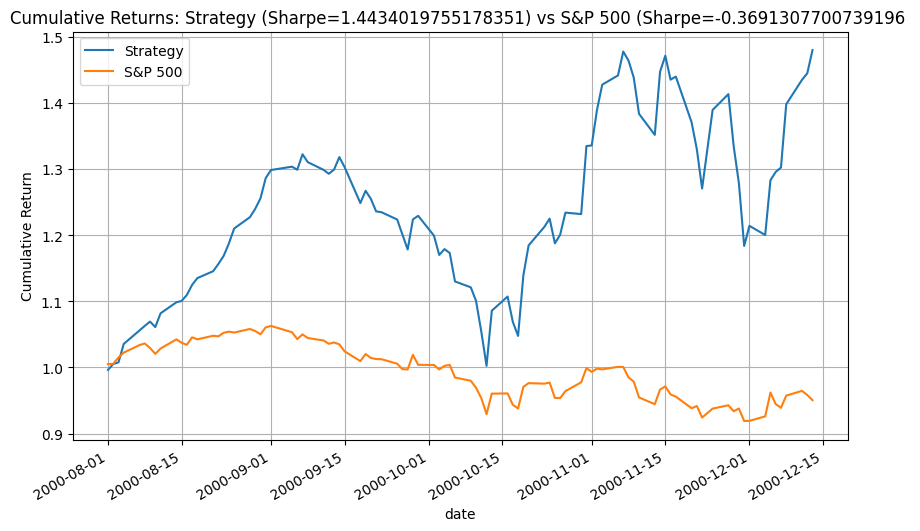

In [7]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + combined_returns).cumprod() 
sp_ret = daily.groupby('date')['sprtrn'].mean()

strat_start = unique_months.iloc[7].to_timestamp()
sp_ret = sp_ret.loc[strat_start:]

cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = np.sqrt(combined_returns.shape[0]) * (combined_returns.mean() / combined_returns.std())
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

In [11]:
combined_returns

date
2000-08-01   -0.010199
2000-08-02    0.011040
2000-08-03    0.003920
2000-08-04    0.031780
2000-08-07    0.024365
                ...   
2000-12-07    0.017940
2000-12-08    0.099359
2000-12-11    0.044720
2000-12-12    0.026630
2000-12-13    0.057143
Name: strategy_return, Length: 95, dtype: float64

<Axes: title={'center': 'Cumulative Strategy Returns'}, xlabel='date'>

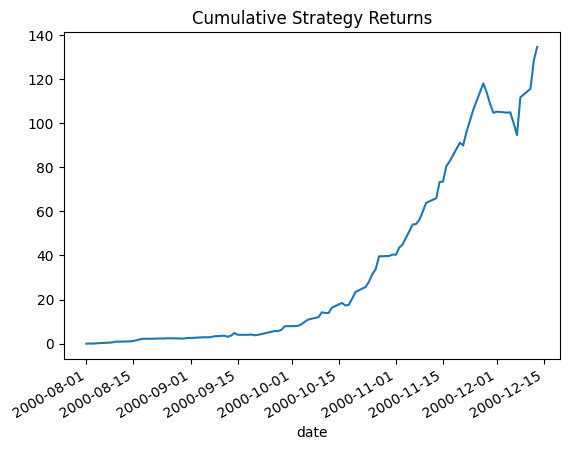

In [8]:
combined_returns = combined_returns.sort_index()

# Convert to DataFrame and calculate cumulative returns
results_df = pd.DataFrame({
    'daily_return': combined_returns,
    'cumulative_return': (1 + combined_returns).cumprod() - 1  # Geometric compounding
})

# Now you can plot:
results_df['cumulative_return'].plot(title='Cumulative Strategy Returns')

In [9]:
combined_returns

date
2000-08-01   -0.013437
2000-08-02    0.086483
2000-08-03   -0.035922
2000-08-04    0.126855
2000-08-07    0.206109
                ...   
2000-12-07   -0.053528
2000-12-08    0.179131
2000-12-11    0.034629
2000-12-12    0.110182
2000-12-13    0.047174
Name: strategy_return, Length: 95, dtype: float64

<Axes: title={'center': 'Cumulative Strategy Returns'}, xlabel='date'>

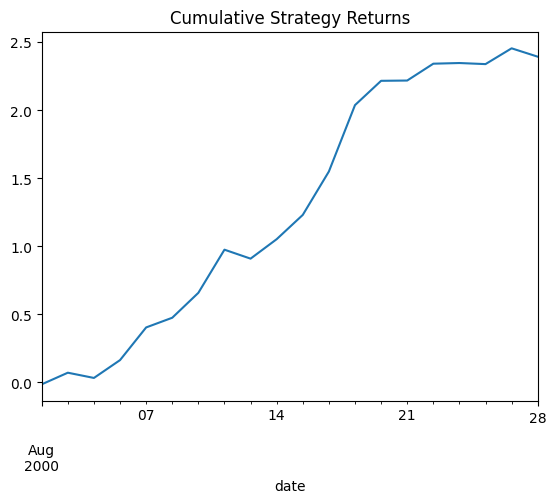

In [10]:
results_df['cumulative_return'].iloc[0:20].plot(title='Cumulative Strategy Returns')

In [11]:
sharpe = np.sqrt(95) * (combined_returns.mean() / mean_daily_returns.std())
sharpe

np.float64(7.2866841729047085)

In [14]:
max_row = daily.loc[daily['DlyRet'].idxmax()]
max_row

date          2000-03-06 00:00:00
PERMCO                      13537
PERMNO                      81283
SICCD                        3570
NAICS                           0
DlyRet                   4.045455
sprtrn                  -0.012695
year_month                2000-03
Name: 361324, dtype: object

In [5]:
index_df = pd.read_csv('Predictors/FirmCharacIndex.csv')
index_df

,Unnamed: 0,date,PERMNO,gvkey,pls_index
0,0,2000-01-31,10025,11903,-3.107469
1,1,2000-01-31,10089,12143,-1.304217
2,2,2000-01-31,10155,12094,-2.892794
3,3,2000-01-31,10182,12171,5.863377
4,4,2000-01-31,10256,12226,-3.608628
...,...,...,...,...,...
520167,520167,2024-12-31,93426,185138,-0.052260
520168,520168,2024-12-31,93427,179583,3.371618
520169,520169,2024-12-31,93429,184500,5.908846
520170,520170,2024-12-31,93434,184259,-4.831854


In [6]:
merged = utils.merge_pls_with_asof(daily, index_df)
merged = merged.fillna(0)
merged

Processing 7762 common PERMNOs...
Processing PERMNO 1/7762
Processing PERMNO 1001/7762
Processing PERMNO 2001/7762
Processing PERMNO 3001/7762
Processing PERMNO 4001/7762
Processing PERMNO 5001/7762
Processing PERMNO 6001/7762
Processing PERMNO 7001/7762
Adding 1242 PERMNOs without PLS data...
Combining results...


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,year_month,pls_index
0,2000-01-31,7953,10001,4920,0,-0.029851,0.025218,2000-01,0.000000
1,2000-01-31,7954,10002,6020,0,-0.005236,0.025218,2000-01,0.000000
2,2000-01-31,7965,10009,6030,0,-0.004255,0.025218,2000-01,0.000000
3,2000-01-31,7969,10012,3670,0,-0.033333,0.025218,2000-01,0.000000
4,2000-01-31,1728,10016,3560,0,0.038168,0.025218,2000-01,0.000000
...,...,...,...,...,...,...,...,...,...
1441513,2000-10-05,7428,92690,6798,0,-0.006711,0.001367,2000-10,0.710286
1441514,2000-10-05,7407,92807,6020,0,0.000000,0.001367,2000-10,0.117273
1441515,2000-10-05,7378,92874,3690,0,-0.059701,0.001367,2000-10,-0.907260
1441516,2000-10-05,7323,92930,3714,0,-0.011321,0.001367,2000-10,4.626466


In [7]:
# Keeping track of the return over all the data
all_raw_predictions = []

for i in range(0, len(unique_months) - 6 - 1):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+6]
    test_month = unique_months.iloc[i+7]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (merged['year_month'] >= train_start) & (merged['year_month'] <= train_end)
    test_mask = merged['year_month'] == test_month

    tr_df = merged[train_mask].copy()
    te_df = merged[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

    #print(test_df.shape)
    
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions = utils.train_DNN(train_df, test_df, features, cat_features, epochs=4)

    #print(strat_returns.shape)
    # Right after getting strat_returns
    #print(f"strat_returns stats: min={strat_returns.min()}, max={strat_returns.max()}, nan_count={strat_returns.isna().sum()}")
    #print(f"strat_returns shape: {strat_returns.shape}")
    #print(f"test_df shape: {test_df.shape}")

    # Add strat_returns as a new column to test_df
    #test_df['strat_return'] = strat_returns 

    # After assigning to test_df
    test_df['strat_return'] = strat_returns.values 
    #print(f"test_df['strat_return'] nan_count: {test_df['strat_return'].isna().sum()}")

    # Calculate mean returns by date
    mean_daily_returns = test_df.groupby('date')['strat_return'].mean()

    # Check if the groupby operation is the issue
    #mean_daily_returns = test_df.groupby('date')['strat_return'].mean()
    #print(f"mean_daily_returns nan_count: {mean_daily_returns.isna().sum()}")
    
    #print(mean_daily_returns.shape)
    all_strategy_returns.append(mean_daily_returns)






# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-07. Testing on 2000-08.
['DlyRet', 'sprtrn', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 516 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:51, 17.09s/it]

Epoch 1/4, Loss: -0.6767, Train Sharpe: 1.3908, Test Sharpe: 1.2096


Training:  75%|██████████████████████████▎        | 3/4 [00:54<00:18, 18.29s/it]

Epoch 3/4, Loss: -1.3135, Train Sharpe: 1.6550, Test Sharpe: 1.4923


Training: 100%|███████████████████████████████████| 4/4 [01:10<00:00, 17.58s/it]

Epoch 4/4, Loss: -1.3689, Train Sharpe: 1.6328, Test Sharpe: 1.4852
Training completed! Best test Sharpe ratio: 1.4923


NameError: name 'strat_returns' is not defined

In [ ]:
combined_returns

In [8]:
# Handle duplicate dates (if any) by taking the mean
#combined_returns = combined_returns.groupby(level=0).mean()

# Sort by date to ensure chronological order
combined_returns = combined_returns.sort_index()

# Convert to DataFrame and calculate cumulative returns
results_df = pd.DataFrame({
    'daily_return': combined_returns,
    'cumulative_return': (1 + combined_returns).cumprod() - 1  # Geometric compounding
})

# Now you can plot:
results_df['cumulative_return'].plot(title='Cumulative Strategy Returns')

NameError: name 'combined_returns' is not defined